# Ising transition with machine learning
Inspired by a [blog post by Carsten Bauer](https://juliaphysics.github.io/PhysicsTutorials.jl/tutorials/machine_learning/ml_ising/ml_ising.html).

Our aim is to use machine learning techniques to identify the Onsager solution to the Ising problem. The Onsager solution gives the termperature when the magnet undergoes the transition from paramagnetic to ferromagnetic phases.



For this, we need to implement a Monte-Carlo simulation of the magnetic moments: we iterate a random configuration of spins and flip a spin site if the Metropolis criteria is met
$$
 P = \min \left\{ 1, e^{- \beta \Delta E} \right\},
$$

with $\Delta E$ being the energy difference if the spin is flipped, and $\beta = 1/T$ where $T$ is the temperature of the system.

$\Delta E$ only depends on the local neighbours of the spin site, and thus can be evaluated by only considering the surrounding neighbours. The Hamiltonian our *simplified* system may be written
$$
H = \sum_{\left\langle i,j \right\rangle} \sigma_i \sigma_j,
$$

where the sum is over neighbouring sites, and $\sigma_i$ represent the spin vectors. For our simulation, we will allow only $-1$ and $1$ as possible values for the spin, representing up and down spins.


The exact Onsager solution is:


In [1]:
const Onsager = 1/(1/2*log(1+sqrt(2)))

2.269185314213022

## Creating the Monte-Carlo simulation

As we'll need a lot of simulated data to train a machine learning model, so we'll leverage [Julia's distributed computing](https://docs.julialang.org/en/v1/stdlib/Distributed/) techniques to process simulations in parallel processes.

We can configure this setup for $8$ processes using a master-worker communication topology:

In [2]:
using Distributed

if nprocs() < 8
   addprocs(8 - nprocs(), topology=:master_worker) 
end

@everywhere begin
    import Pkg
    Pkg.activate("../..")
end

      From worker 6:	  Activating environment at `~/Developer/julia-resources/Project.toml`
      From worker 3:	  Activating environment at `~/Developer/julia-resources/Project.toml`
      From worker 4:	  Activating environment at `~/Developer/julia-resources/Project.toml`
      From worker 7:	  Activating environment at `~/Developer/julia-resources/Project.toml`
      From worker 8:	  Activating environment at `~/Developer/julia-resources/Project.toml`
      From worker 5:	  Activating environment at `~/Developer/julia-resources/Project.toml`


  Activating environment at `~/Developer/julia-resources/Project.toml`


      From worker 2:	  Activating environment at `~/Developer/julia-resources/Project.toml`


Next we design our Monte-Carlo function -- to squeeze performance, we utilize neighbour lookup vectors. This is considerably faster than e.g. a 2-dimensional convolution, since we can benefit from caching layers when accessing our arrays.

*NB:* I tried a few different implementations using [DSP](https://github.com/JuliaDSP/DSP.jl) `conv` functions, but the performance benefits it's only seen for very large lattice sizes -- which in general, we won't be using. Consequently, just raw Julia (C speed) `for`-loops are an excellent, albeit naive, way to gain speed.

We use the `@everywhere` macro so that our structures and functions are defined in all processes. We start by defining a structure storing our Ising problem:

In [3]:
@everywhere using Parameters

@everywhere @with_kw struct IsingModel
    size::Int = 8
    T::Float64 = 5
end

The Monte-Carlo method itself creates lookup `Matrix` for each direction (up, down, left, right), and then iterates over each spin site, calculates the Metropolis condition, and flips the spin if required, *before* calculating the next cell.

Sites must be flipped individually, and not in batches.

We add a `rate` parameter, which controls how often we copy the lattice configuration and store it in the return vector.

In [4]:
@everywhere function montecarlo(
        ism::IsingModel;
        nsweeps::Int=10^7, 
        rate::Int=5_000
    )::Vector{Matrix{Int}}

    β = 1 / ism.T
    L = ism.size

    lattice = rand([-1, 1], L, L)
    
    # store for progress frames
    intermediary = []
    
    # lookup matrix
    indexes = reshape(1:L^2, (L, L))
    
    # caches
    up = circshift(indexes, (-1,0))
    right = circshift(indexes, (0,-1))
    down = circshift(indexes,(1,0))
    left = circshift(indexes,(0,1))
    
    # main loop
    for sweep in 1:nsweeps

        for i in eachindex(lattice)
            ΔE = 2.0 * lattice[i]
            ΔE *= lattice[up[i]] + lattice[right[i]] + lattice[down[i]] + lattice[left[i]]

            if ΔE <= 0 || rand() < exp(- β * ΔE)
                lattice[i] *= -1 # it is very important to update before calculating the next site
            end
        end

        # store configuration
        if iszero(mod(sweep, rate))
            push!(intermediary, copy(lattice))
        end
        
    end

    intermediary
end

### Visualisation functions

Next, we'll add a few visualisation functions so we can inspect our simulations:

In [5]:
using Plots

function visualise(m::Matrix)
   heatmap(Gray.(Float64.(m)), ticks=false) 
end

function visualise(v::Vector; N=50)
    @assert N < length(v)
    selection = [v[i] for i in 1:(length(v) ÷ N):length(v)]
    plot(map(visualise, selection)...)
end

visualise (generic function with 2 methods)

So far then, we have this:

 13.436281 seconds (4.43 k allocations: 1.844 MiB, 0.03% compilation time)


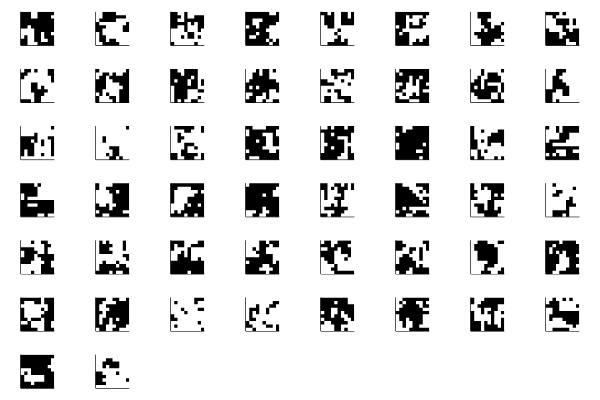

In [6]:
ism = IsingModel(size=10, T=3)

res = @time montecarlo(ism)
visualise(res, N=50)

## Parallelization

We'll use the abstraced `pmap` to handle distributing our simulations to the available workers. So we can track the progress a little, we'll use [`ProgressMeter.jl`](https://github.com/timholy/ProgressMeter.jl). We'll create a few overloaded methods to faciliate this, depending on whether we want to run the same `IsingModel`, or different ones:

In [7]:
using ProgressMeter

function montecarlo(ism::IsingModel, s::Symbol; N::Int=7, kwargs...)
    @assert s == :parallel
    @showprogress pmap(_ -> montecarlo(ism; kwargs...), 1:N)
end

function montecarlo(isms::Vector{IsingModel}, s::Symbol; kwargs...)
    @assert s == :parallel
    @showprogress pmap(ism -> montecarlo(ism; kwargs...), isms)
end

montecarlo (generic function with 3 methods)

Allowing us to run multiple parallel simulations in effectively the same period of time:

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


 16.781731 seconds (5.95 M allocations: 344.395 MiB, 0.60% gc time, 7.63% compilation time)


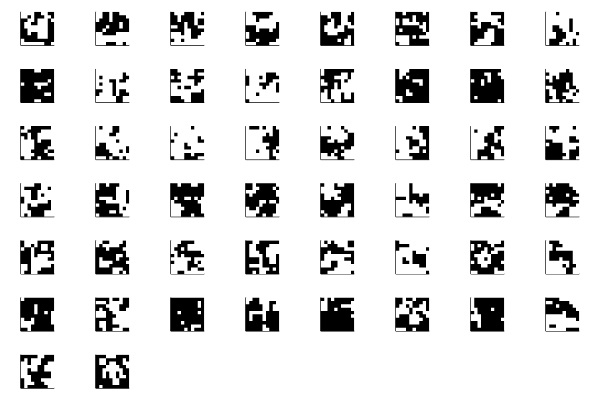

In [8]:
res = @time montecarlo(ism, :parallel)

visualise(res[1])

## Training data

Our strategy is to simulate the Ising problem for a range of temperatures in which we (*a prior*) believe the transition temperature to be -- that is, we will have some temperatures at which the spins are expected to be ordered, and temperatures at which they are expected to be disordered.

In order to prepare our data, we want to flatten the lattice configurations, and exploit the $Z_2$ symmetry of the Ising Hamiltonian, stating any configuration of spins has identical energy under a complete spin flip 
$$
\sigma_i \rightarrow -\sigma_i,
$$
allowing us to double the data set.

In [9]:
function prepare(resmap::Dict{Tp, Vector{Matrix{Float64}}}, T::Tp)::Matrix{Float64} where Tp <: Float64 
    lattice = cat(resmap[T]..., dims=3) # convert to 3d array
    
    # flatten and cast to float
    size = length(lattice[:, :, 1])
    flat = Float64.(reshape(lattice, (size, :)))
    
    # concatanate Z2 symmetry partners
    hcat(flat, -flat)
end

prepare (generic function with 1 method)

For our temperature range, we'll choose 15 equally space temperature values:

In [10]:
Trange = LinRange(1.1, 3.4, 15)

15-element LinRange{Float64}:
 1.1,1.26429,1.42857,1.59286,1.75714,…,2.74286,2.90714,3.07143,3.23571,3.4

Which we'll generate and store the results for:

In [11]:
isms = [IsingModel(10, T) for T in Trange]
results = montecarlo(isms, :parallel)

size(results)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


(15,)

And store in a more interpretable manner:

In [12]:
resmap = Dict{Float64, Vector{Matrix{Float64}}}( T => res for (T, res) in zip(Trange, results))

Dict{Float64, Vector{Matrix{Float64}}} with 15 entries:
  3.4     => [[-1.0 -1.0 … -1.0 -1.0; 1.0 -1.0 … -1.0 -1.0; … ; -1.0 1.0 … -1.0…
  2.25    => [[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0…
  1.42857 => [[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0…
  3.07143 => [[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; -1.0 -1.0 … -1.0 1.0; …
  1.75714 => [[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1…
  1.59286 => [[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1…
  1.92143 => [[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1…
  2.57857 => [[1.0 -1.0 … 1.0 1.0; -1.0 -1.0 … -1.0 -1.0; … ; 1.0 1.0 … 1.0 1.0…
  2.90714 => [[-1.0 -1.0 … 1.0 1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0…
  2.74286 => [[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0…
  1.1     => [[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0…
  3.23571 => [[1.0 -1.0 … -1.0 1.0; 1.0 1.0 … -1.0 1.

### Temperature seperation

We'll only train the neural network on data we are confident on, and allow it to learn the rest -- this represents training the model only on data we are confident as being either ferro- or paramagnetic. Choosing the highest and lowest temperature of our simulated set, we'll prepare the data in the usual manner desired by Flux:

In [13]:
lowT = prepare(resmap, Trange[1])
highT = prepare(resmap, Trange[end])

n = size(lowT, 2) # number of simulations in a run
X = hcat(lowT, highT)

labels = vcat(fill(1, n), fill(0, n))

length(labels)

8000

We now have 8000 individual trials, which we'll repeat 10 times for the purpose of brevity. We also use the convenience function `Flux.onehotbatch` to generate the one-hot matrix for training:

In [14]:
using Flux
using Flux: onehotbatch

Y = onehotbatch(labels, 0:1)

# repeat 10 times
dataset = Iterators.repeated((X, Y), 10)
;

## Learning the transition

We'll use a two layer, one hidden, one output, dense neural network with ReLU activation -- essentially a *Classifier*. We ensure the input of the network is the lattice size (i.e. $L^2$), and that the output has two neurons, representing ferro- and paramagnetic confidence.


In [15]:
NN = Chain(
    Dense(ism.size^2, 10, relu), # input size is L^2
    Dense(10, 2), # 2 output neurons
    
    softmax
)

Chain(Dense(100, 10, relu), Dense(10, 2), softmax)

### Confidence measures

Next we implement a function for extracting the networks confidence across all of our trials -- this is simply evaluating the prediction of the network across all of the lattices for different temperatures, taking the average of the result for a *specific* temperature, and sorting the dictionary by temperatures:

In [16]:
using Statistics

function confidence(NN::Chain, resmap::Dict{Float64, Vector{Matrix{Float64}}})
    Dict{Float64, Vector{Float64}}(
        first(i) => vec(mean(NN(prepare(resmap, first(i))), dims=2))
        for i in resmap
    ) |> sort    
end

confidence (generic function with 1 method)

We can view the confidence of our untrained network:

In [17]:
res = confidence(NN, resmap)

OrderedCollections.OrderedDict{Float64, Vector{Float64}} with 15 entries:
  1.1     => [0.706504, 0.293496]
  1.26429 => [0.707628, 0.292372]
  1.42857 => [0.70941, 0.29059]
  1.59286 => [0.711722, 0.288278]
  1.75714 => [0.71676, 0.28324]
  1.92143 => [0.7199, 0.2801]
  2.08571 => [0.725745, 0.274255]
  2.25    => [0.738956, 0.261044]
  2.41429 => [0.747137, 0.252863]
  2.57857 => [0.753856, 0.246144]
  2.74286 => [0.755406, 0.244594]
  2.90714 => [0.757546, 0.242454]
  3.07143 => [0.758432, 0.241568]
  3.23571 => [0.761114, 0.238886]
  3.4     => [0.761594, 0.238406]

To visualise this a little better, we define a function for plotting these values, including a line for the exact solution:

In [18]:
function plotconfidence(res)
   p = plot(
        keys(res) |> collect,
        reduce(hcat, values(res))',
        
        marker=:circle,
        labels=["paramagnetic" "ferromagnetic"]
    )
    xlabel!("T")
    ylabel!("CNN Confidence")
    
    plot!([Onsager, Onsager], [0, 1], ls=:dash, c=:black, label="Onsager Solution")
    p
end

plotconfidence (generic function with 1 method)

And plot:

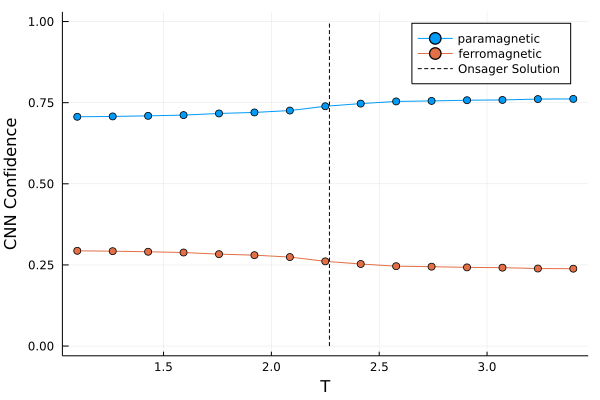

In [19]:
plotconfidence(confidence(NN, resmap))

### Training
For training the network, we calculate the crossentropy of the predictions as the loss function, and optimize the neurons with ADAM:

In [20]:
using Flux: crossentropy

loss(x, y) = crossentropy(NN(x), y)
opt = ADAM()

@showprogress for i in 1:100
    Flux.train!(loss, params(NN), dataset, opt)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


After approximately 20 seconds of training on just the CPU, we can inspect our network's confidence again:

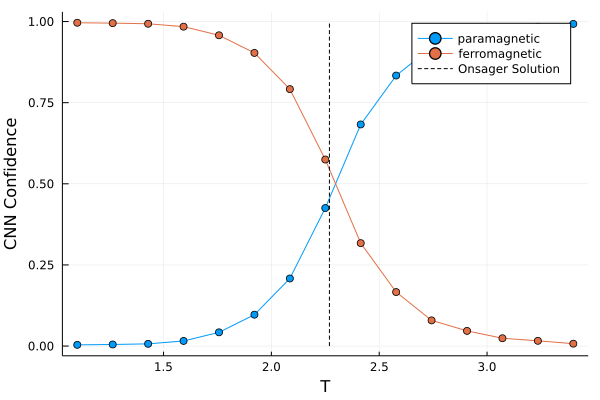

In [21]:
plotconfidence(confidence(NN, resmap))

And indeed the point of maximal confusion in the network is *almost exactly* the Onsager solution.